# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [this data set](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion.
3. Summarise your results in a table and comment on them in the report.
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load KMNIST training dataset
train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)

# Data Augmentation
transform_augmented = transforms.Compose([
    transforms.RandomAffine(
        degrees=30,                  # Rotate between -30 to +30 degrees
        translate=(0.1, 0.1),        # Translate by up to 10% in both directions
    ),
    transforms.ToTensor()
])

augmented_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform_augmented)

train_dataset = ConcatDataset([train_dataset, augmented_dataset])

# Load KMNIST test dataset
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example: Get a batch of data
images, labels = next(iter(train_loader))
print(f'Batch shape: {images.shape}, Labels: {labels[:10]}')


100%|██████████| 18.2M/18.2M [00:10<00:00, 1.81MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 377kB/s]
100%|██████████| 3.04M/3.04M [00:01<00:00, 1.78MB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 8.85MB/s]

Batch shape: torch.Size([64, 1, 28, 28]), Labels: tensor([0, 4, 1, 7, 6, 0, 1, 0, 9, 5])


In [3]:
from torch.utils.data import random_split

full_train_dataset = train_dataset
# Define split sizes (e.g. 90% train, 10% val)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

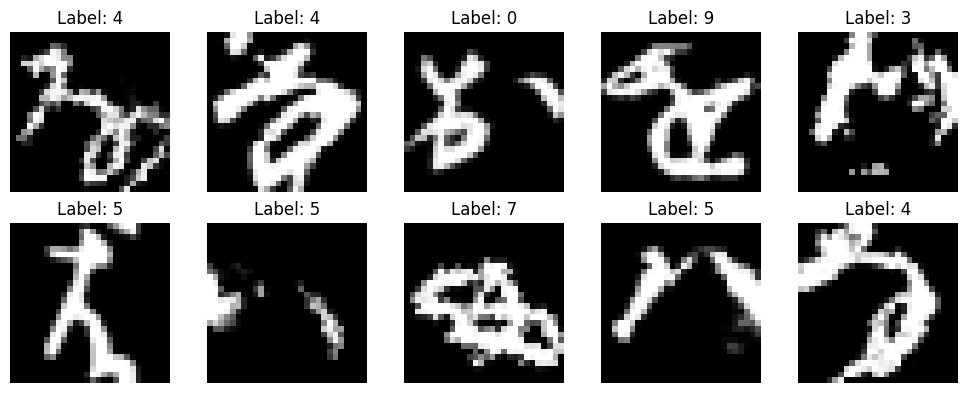

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
head = [train_dataset[i] for i in range (10)]
images = [h[0] for h in head]
labels = [h[1] for h in head]
for i, ax in enumerate(axes.flat):
  img = images[i].squeeze(0)
  ax.imshow(img, cmap='gray')
  ax.set_title(f"Label: {labels[i]}")
  ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
import torch.nn as nn
import torch.optim as optim

### FULLY CONNECTED ARCHITECTURE

In [7]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.fc(x)

In [16]:
class FCNN_dropout(nn.Module):
    def __init__(self):
        super(FCNN_dropout, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.fc(x)

### CONVOLUTIONAL ARCHITECTURE


In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7

            nn.Conv2d(32, 64, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 4 x 4
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)


### CONVOLUTIONAL ARCHITECTURE with DROPOUT



In [10]:
class CNN_dropout(nn.Module):
    def __init__(self):
        super(CNN_dropout, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14
            nn.Dropout(0.5),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 4 x 4
            nn.Dropout(0.2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)

### TRAINING CYCLE

In [11]:
def train(model, train_loader, validation_loader, optimizer, criterion, train_data = False):
    model.train()
    if train_data:
        train_total_loss, train_total_correct = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        if train_data:
            train_total_loss += loss.item()
            train_total_correct += (output.argmax(1) == y).sum().item()

    model.eval()
    total_loss, total_correct = 0, 0
    # WE USE THE METRICS IN THE VALIDATION
    for x, y in validation_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_correct += (output.argmax(1) == y).sum().item()

    acc = total_correct / len(validation_loader.dataset)

    if train_data:
        train_acc = train_total_correct / len(train_loader.dataset)
        return total_loss / len(validation_loader), acc, train_total_loss / len(train_loader), train_acc

    return total_loss / len(validation_loader), acc


In [12]:
### MODEL TEST

def model_test(model, test_loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            total_loss += loss.item()
            total_correct += (output.argmax(1) == y).sum().item()

    acc = total_correct / len(test_loader.dataset)

    return total_loss / len(test_loader), acc

CNN w/out dropout. Only validation and test.

In [22]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    validation_loss, validation_acc = train(model, train_loader, val_loader, optimizer, criterion)
    print(f"Epoch {epoch+1} ON THE VALIDATION - Loss: {validation_loss:.4f}, Accuracy: {validation_acc*100:.2f}%")
test_loss, test_acc = model_test(model, test_loader, criterion)
print(f"TEST SET - Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")

Epoch 1 ON THE VALIDATION - Loss: 0.2373, Accuracy: 92.52%
Epoch 2 ON THE VALIDATION - Loss: 0.1615, Accuracy: 95.10%
Epoch 3 ON THE VALIDATION - Loss: 0.1336, Accuracy: 96.02%
Epoch 4 ON THE VALIDATION - Loss: 0.1114, Accuracy: 96.71%
Epoch 5 ON THE VALIDATION - Loss: 0.0957, Accuracy: 97.01%
Epoch 6 ON THE VALIDATION - Loss: 0.1052, Accuracy: 96.90%
Epoch 7 ON THE VALIDATION - Loss: 0.1009, Accuracy: 97.15%
Epoch 8 ON THE VALIDATION - Loss: 0.0881, Accuracy: 97.48%
Epoch 9 ON THE VALIDATION - Loss: 0.0819, Accuracy: 97.58%
Epoch 10 ON THE VALIDATION - Loss: 0.0885, Accuracy: 97.57%
TEST SET - Loss: 0.2314, Accuracy: 95.70%


CNN w/out dropout. Train, validation and test.

In [18]:
# now we track also the train history
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_history = []
validation_history = []

for epoch in range(10):
    validation_loss, validation_acc, train_loss, train_acc = train(model, train_loader, val_loader, optimizer, criterion, train_data = True)
    train_history.append(train_loss)
    validation_history.append(validation_loss)
    print(f"Epoch {epoch+1} ON THE VALIDATION - Loss: {validation_loss:.4f}, Accuracy: {validation_acc*100:.2f}% | ON THE TRAINING - Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}% ")
test_loss, test_acc = model_test(model, test_loader, criterion)
print(f"TEST SET - Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")


Epoch 1 ON THE VALIDATION - Loss: 0.2510, Accuracy: 92.15% | ON THE TRAINING - Loss: 0.4967, Accuracy: 83.89% 
Epoch 2 ON THE VALIDATION - Loss: 0.1505, Accuracy: 95.28% | ON THE TRAINING - Loss: 0.1788, Accuracy: 94.42% 
Epoch 3 ON THE VALIDATION - Loss: 0.1349, Accuracy: 95.78% | ON THE TRAINING - Loss: 0.1296, Accuracy: 95.95% 
Epoch 4 ON THE VALIDATION - Loss: 0.1202, Accuracy: 96.38% | ON THE TRAINING - Loss: 0.1013, Accuracy: 96.81% 
Epoch 5 ON THE VALIDATION - Loss: 0.0960, Accuracy: 97.10% | ON THE TRAINING - Loss: 0.0859, Accuracy: 97.23% 
Epoch 6 ON THE VALIDATION - Loss: 0.0908, Accuracy: 97.27% | ON THE TRAINING - Loss: 0.0780, Accuracy: 97.52% 
Epoch 7 ON THE VALIDATION - Loss: 0.0935, Accuracy: 97.17% | ON THE TRAINING - Loss: 0.0676, Accuracy: 97.82% 
Epoch 8 ON THE VALIDATION - Loss: 0.0880, Accuracy: 97.27% | ON THE TRAINING - Loss: 0.0650, Accuracy: 97.91% 
Epoch 9 ON THE VALIDATION - Loss: 0.0863, Accuracy: 97.46% | ON THE TRAINING - Loss: 0.0587, Accuracy: 98.13% 
E

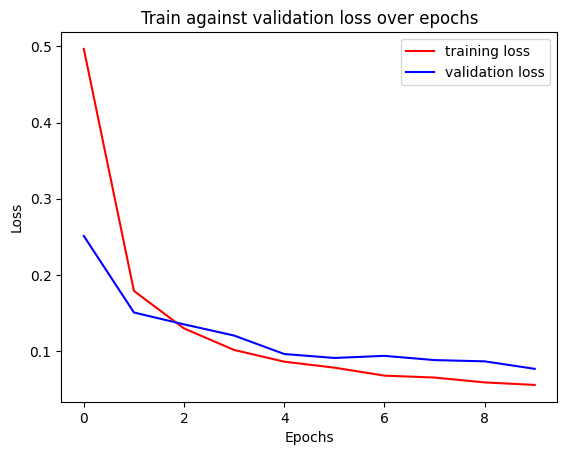

In [19]:
from matplotlib import pyplot as plt

plt.plot(train_history, c = "red", label = "training loss")
plt.plot(validation_history, c = "blue", label = "validation loss")
plt.legend()
plt.title("Train against validation loss over epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

CNN with dropout. Only validation and test.

In [29]:
model = CNN_dropout().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    validation_loss, validation_acc = train(model, train_loader, val_loader, optimizer, criterion)
    print(f"Epoch {epoch+1} ON THE VALIDATION - Loss: {validation_loss:.4f}, Accuracy: {validation_acc*100:.2f}%")
test_loss, test_acc = model_test(model, test_loader, criterion)
print(f"TEST SET - Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")

Epoch 1 ON THE VALIDATION - Loss: 0.3066, Accuracy: 90.36%
Epoch 2 ON THE VALIDATION - Loss: 0.1936, Accuracy: 94.24%
Epoch 3 ON THE VALIDATION - Loss: 0.1634, Accuracy: 95.09%
Epoch 4 ON THE VALIDATION - Loss: 0.1355, Accuracy: 95.97%
Epoch 5 ON THE VALIDATION - Loss: 0.1208, Accuracy: 96.28%
Epoch 6 ON THE VALIDATION - Loss: 0.1188, Accuracy: 96.38%
Epoch 7 ON THE VALIDATION - Loss: 0.1113, Accuracy: 96.62%
Epoch 8 ON THE VALIDATION - Loss: 0.1012, Accuracy: 96.97%
Epoch 9 ON THE VALIDATION - Loss: 0.0936, Accuracy: 97.18%
Epoch 10 ON THE VALIDATION - Loss: 0.0879, Accuracy: 97.24%
TEST SET - Loss: 0.1537, Accuracy: 95.84%


CNN with dropout. Train, validation and test.

In [20]:
model = CNN_dropout().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_history = []
validation_history = []

for epoch in range(10):
    validation_loss, validation_acc, train_loss, train_acc = train(model, train_loader, val_loader, optimizer, criterion, train_data = True)
    train_history.append(train_loss)
    validation_history.append(validation_loss)
    print(f"Epoch {epoch+1} ON THE VALIDATION - Loss: {validation_loss:.4f}, Accuracy: {validation_acc*100:.2f}% | ON THE TRAINING - Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}% ")
test_loss, test_acc = model_test(model, test_loader, criterion)
print(f"TEST SET - Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")

Epoch 1 ON THE VALIDATION - Loss: 0.2839, Accuracy: 91.62% | ON THE TRAINING - Loss: 0.6964, Accuracy: 76.98% 
Epoch 2 ON THE VALIDATION - Loss: 0.1900, Accuracy: 94.27% | ON THE TRAINING - Loss: 0.3214, Accuracy: 89.77% 
Epoch 3 ON THE VALIDATION - Loss: 0.1423, Accuracy: 95.66% | ON THE TRAINING - Loss: 0.2502, Accuracy: 91.96% 
Epoch 4 ON THE VALIDATION - Loss: 0.1308, Accuracy: 96.07% | ON THE TRAINING - Loss: 0.2201, Accuracy: 93.07% 
Epoch 5 ON THE VALIDATION - Loss: 0.1259, Accuracy: 96.16% | ON THE TRAINING - Loss: 0.1957, Accuracy: 93.75% 
Epoch 6 ON THE VALIDATION - Loss: 0.1159, Accuracy: 96.41% | ON THE TRAINING - Loss: 0.1846, Accuracy: 94.13% 
Epoch 7 ON THE VALIDATION - Loss: 0.1084, Accuracy: 96.73% | ON THE TRAINING - Loss: 0.1742, Accuracy: 94.49% 
Epoch 8 ON THE VALIDATION - Loss: 0.1068, Accuracy: 96.63% | ON THE TRAINING - Loss: 0.1681, Accuracy: 94.72% 
Epoch 9 ON THE VALIDATION - Loss: 0.0963, Accuracy: 96.97% | ON THE TRAINING - Loss: 0.1625, Accuracy: 94.92% 
E

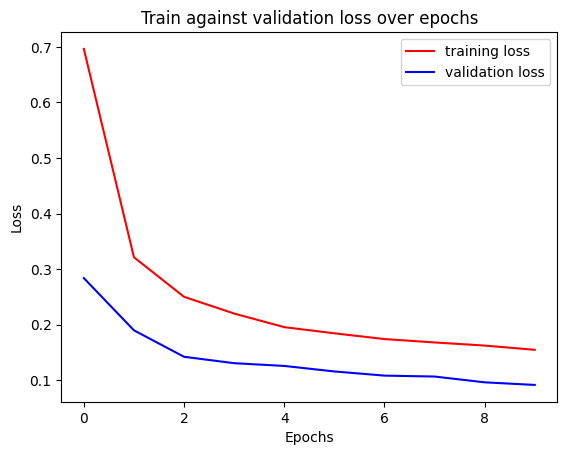

In [21]:
from matplotlib import pyplot as plt

plt.plot(train_history, c = "red", label = "training loss")
plt.plot(validation_history, c = "blue", label = "validation loss")
plt.legend()
plt.title("Train against validation loss over epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

FCNN. Only validation and test.

In [14]:
model = FCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    validation_loss, validation_acc = train(model, train_loader, val_loader, optimizer, criterion)
    print(f"Epoch {epoch+1} ON THE VALIDATION - Loss: {validation_loss:.4f}, Accuracy: {validation_acc*100:.2f}%")
test_loss, test_acc = model_test(model, test_loader, criterion)
print(f"TEST SET - Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")

Epoch 1 ON THE VALIDATION - Loss: 0.4784, Accuracy: 84.91%
Epoch 2 ON THE VALIDATION - Loss: 0.4282, Accuracy: 86.99%
Epoch 3 ON THE VALIDATION - Loss: 0.3281, Accuracy: 89.95%
Epoch 4 ON THE VALIDATION - Loss: 0.3210, Accuracy: 90.04%
Epoch 5 ON THE VALIDATION - Loss: 0.3048, Accuracy: 90.77%
Epoch 6 ON THE VALIDATION - Loss: 0.2903, Accuracy: 91.33%
Epoch 7 ON THE VALIDATION - Loss: 0.2765, Accuracy: 91.85%
Epoch 8 ON THE VALIDATION - Loss: 0.2552, Accuracy: 92.57%
Epoch 9 ON THE VALIDATION - Loss: 0.2701, Accuracy: 92.18%
Epoch 10 ON THE VALIDATION - Loss: 0.2638, Accuracy: 92.34%
TEST SET - Loss: 0.4682, Accuracy: 89.38%


In [17]:
model = FCNN_dropout().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    validation_loss, validation_acc = train(model, train_loader, val_loader, optimizer, criterion)
    print(f"Epoch {epoch+1} ON THE VALIDATION - Loss: {validation_loss:.4f}, Accuracy: {validation_acc*100:.2f}%")
test_loss, test_acc = model_test(model, test_loader, criterion)
print(f"TEST SET - Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")

Epoch 1 ON THE VALIDATION - Loss: 0.7625, Accuracy: 76.54%
Epoch 2 ON THE VALIDATION - Loss: 0.6304, Accuracy: 80.66%
Epoch 3 ON THE VALIDATION - Loss: 0.5743, Accuracy: 82.69%
Epoch 4 ON THE VALIDATION - Loss: 0.5358, Accuracy: 83.55%
Epoch 5 ON THE VALIDATION - Loss: 0.5159, Accuracy: 84.68%
Epoch 6 ON THE VALIDATION - Loss: 0.4977, Accuracy: 85.05%
Epoch 7 ON THE VALIDATION - Loss: 0.4823, Accuracy: 85.18%
Epoch 8 ON THE VALIDATION - Loss: 0.4620, Accuracy: 86.18%
Epoch 9 ON THE VALIDATION - Loss: 0.4549, Accuracy: 86.69%
Epoch 10 ON THE VALIDATION - Loss: 0.4414, Accuracy: 86.88%
TEST SET - Loss: 0.5071, Accuracy: 84.51%
